In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [40]:
df=pd.read_excel("covid_World_updated.xlsx")
df.date=pd.to_datetime(df.date,infer_datetime_format=True)
#United States,Brazil,World,India
location_name="United States"
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


### Creating Data Frame with Total Cases lags

In [41]:
from fbprophet import Prophet

In [42]:
def accuracy(realSales_series, prediction_series):

    assert isinstance(realSales_series, pd.Series), 'Real Sales should be in pandas Series format'
    assert isinstance(prediction_series, pd.Series), 'Prediction should be in pandas Series format'
#     prediction_series=np.max(0,prediction_series)
    acc =round((1 - abs(prediction_series - realSales_series)/prediction_series) * 100,2)
    acc.loc[(realSales_series == 0) & (prediction_series != 0)] = 0
    acc.loc[(realSales_series == 0) & (prediction_series == 0)] = np.nan
    #acc.loc[acc > 95] = 100
    acc.loc[acc < 0] = 0
    acc.dropna()
    return acc

In [43]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

In [44]:
def forecasting(df_out,regressor,table,graph):
    
    df_out1=pd.DataFrame(columns=["ds","y"]) 
    
        
    df_out1['y']=df_out['Deaths']
    df_out1['ds']=df_out.index
    
    if regressor=="Confirmed":
        df_out1['ConLag5']=df_out['ConLag5']
#     elif regressor=="Cured":
#         df_out1['CurLag5']=df_out['CurLag5']
#     else:
#         df_out1['ConLag5']=df_out['ConLag5']
#         df_out1['CurLag5']=df_out['CurLag5']
        
        
    df_out1.reset_index(inplace=True,drop=True)
    
    #print(df_out1)
    
        
    model=Prophet(daily_seasonality=True,yearly_seasonality=False)
    
    if regressor=="Confirmed":
        model.add_regressor('ConLag5')
#     elif regressor=="Cured":
#         model.add_regressor('CurLag5')
#     else:
#         model.add_regressor('ConLag5')
#         model.add_regressor('CurLag5')
        
    #print(df_out)    
    model.fit(df_out1)
    
    future = model.make_future_dataframe(periods=5)
    
    if regressor=="Confirmed":
        conlag=list(df_out1['ConLag5'])
        for i in range(5,0,-1):
            conlag.append(list(df_location['total_cases'])[-i])
        #print(conlag)
            
        future['ConLag5']=list(conlag)
        #print(future)
#     elif regressor=="Cured":
#         curlag=list(df_out1['CurLag5'])
#         #curlag.append(list(df_State['Cured'])[-1])
#         for i in range(5,0,-1):
#             curlag.append(list(df_State['Cured'])[-i])

#         future['CurLag5']=list(curlag)
#     else:
#         conlag=list(df_out1['ConLag5'])
#         for i in range(5,0,-1):
#             conlag.append(list(df_State['Confirmed'])[-i])
#         #conlag.append(list(df_State['Confirmed'])[-1])
#         curlag=list(df_out1['CurLag5'])
#         for i in range(5,0,-1):
#             curlag.append(list(df_State['Cured'])[-i])
#         #curlag.append(list(df_State['Cured'])[-1])
#         future['ConLag5']=list(conlag)
#         future['CurLag5']=list(curlag)
#     #print(future)
    
    forecast=model.predict(future)
    if table=="Yes":
        print("Forecasted Table for number of Deaths for location: "+location_name+"\n")
        Forecast=pd.DataFrame()
        Forecast['Day']=forecast['ds']
        Forecast['Forecasted_Death']=[int(x) for x in list(forecast['yhat'])]
        Forecast['Lower Limit']=[int(x) for x in list(forecast['yhat_lower'])]
        Forecast['Upper Limit']=[int(x) for x in list(forecast['yhat_upper'])]
        Forecast.set_index('Day',inplace=True)
        print(Forecast.tail(5))
        
    return list(Forecast['Forecasted_Death'])[-1]

In [45]:
i=29
j=24
table="Yes"
graph="Yes"
regressor="Confirmed"
pred5=[]
while j>=0:
    df.index = pd.DatetimeIndex(df.date)
    df_location=df[df['location']==location_name]
    df_location=df_location[:-i]
    df_location['date']=df_location.index
    df_location.reset_index(inplace = True, drop = True)
    df_out={'Date': df_location.date.to_list(),
             'Deaths':df_location.total_deaths.to_list(),
            'ConLag5':df_location.total_cases.shift(5).to_list(),
           }
    df_out=pd.DataFrame(df_out)
    df_out.columns
    df_out=df_out.dropna()
    df_out.set_index('Date',inplace=True)
    for cols in df_out.columns:
        if cols=="Date":
            continue
        else:
            df_out[cols]=df_out[cols].astype(int)
            
    print('df_out')
    print(df_out)
            
    pred5.append(forecasting(df_out,regressor,table,graph))
    i=i-1
    j=j-1

df_out
            Deaths  ConLag5
Date                       
2020-01-05       0        0
2020-01-06       0        0
2020-01-07       0        0
2020-01-08       0        0
2020-01-09       0        0
...            ...      ...
2020-08-27  179714  5623727
2020-08-28  180824  5668105
2020-08-29  181773  5702611
2020-08-30  182779  5740909
2020-08-31  183069  5779028

[240 rows x 2 columns]
Forecasted Table for number of Deaths for location: United States

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-09-01            184445       183900       184955
2020-09-02            185565       184975       186169
2020-09-03            186790       186221       187404
2020-09-04            187978       187332       188582
2020-09-05            189080       188354       189784
df_out
            Deaths  ConLag5
Date                       
2020-01-05       0        0
2020-01-06       0        0
2020-01-07       0        0
2020-0

Forecasted Table for number of Deaths for location: United States

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-09-11            192846       192373       193321
2020-09-12            193698       193228       194223
2020-09-13            194352       193839       194788
2020-09-14            194781       194242       195383
2020-09-15            195309       194709       195926
df_out
            Deaths  ConLag5
Date                       
2020-01-05       0        0
2020-01-06       0        0
2020-01-07       0        0
2020-01-08       0        0
2020-01-09       0        0
...            ...      ...
2020-09-07  188941  6075652
2020-09-08  189208  6114406
2020-09-09  189679  6150655
2020-09-10  190815  6201726
2020-09-11  191789  6245866

[251 rows x 2 columns]
Forecasted Table for number of Deaths for location: United States

            Forecasted_Death  Lower Limit  Upper Limit
Day                            

Forecasted Table for number of Deaths for location: United States

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-09-21            199975       199601       200347
2020-09-22            200287       199917       200657
2020-09-23            201276       200844       201683
2020-09-24            202435       201991       202893
2020-09-25            203427       202950       203958
df_out
            Deaths  ConLag5
Date                       
2020-01-05       0        0
2020-01-06       0        0
2020-01-07       0        0
2020-01-08       0        0
2020-01-09       0        0
...            ...      ...
2020-09-17  196802  6445288
2020-09-18  197633  6486108
2020-09-19  198589  6519979
2020-09-20  199258  6554820
2020-09-21  199509  6606293

[261 rows x 2 columns]
Forecasted Table for number of Deaths for location: United States

            Forecasted_Death  Lower Limit  Upper Limit
Day                            

In [49]:
df_output=pd.DataFrame()
mape=[]
df_location=df[df['location']==location_name]
real=list(df_location.total_deaths[-25:])
for i in range(len(real)):
    mape.append(mean_absolute_percentage_error(real[i],pred5[i]))
score=accuracy(pd.Series(real),pd.Series(pred5))
df_output['Date']=list(df[df['location']==location_name].date[-25:])
df_output['Real']=real
df_output['Pred']=pred5
df_output['Accuracy']=score
df_output['Error%(MAPE)']=mape
#df_output.set_index(df_output.Date,inplace=True,drop=True)

In [50]:
df_output

,Date,Real,Pred,Accuracy,Error%(MAPE)
0,2020-09-05,187765.0,189080,99.30,0.700344
1,2020-09-06,188538.0,189862,99.30,0.702246
2,2020-09-07,188941.0,190357,99.26,0.749440
3,2020-09-08,189208.0,190837,99.15,0.860957
4,2020-09-09,189679.0,191676,98.96,1.052831
5,2020-09-10,190815.0,192646,99.05,0.959568
6,2020-09-11,191789.0,193692,99.02,0.992236
7,2020-09-12,193016.0,194471,99.25,0.753824
8,2020-09-13,193701.0,194926,99.37,0.632418
9,2020-09-14,194079.0,195059,99.50,0.504949


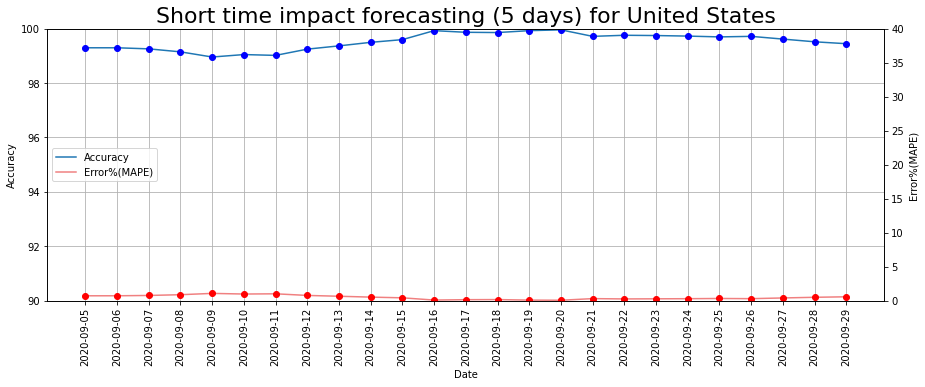

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax1 = plt.subplots()
#df_output.set_index(df_output.Date,inplace=True,drop=True)
ax2 = ax1.twinx()
#r2=round(r2_score(real, pred14),2)*100
title="Short time impact forecasting (5 days) for "+location_name
plt.title(title,fontsize= 22)
ax1.grid()
#plt.xticks(df_output.Date,rotation=90)
ax1.set_ylim(90,100)
ax1.plot(df_output.Date,df_output['Accuracy'],label='Accuracy')
for i in range(len(df_output)):
    ax1.plot(df_output.Date[i:i+1],df_output['Accuracy'][i:i+1],'bo')
ax2.plot(df_output.Date,df_output['Error%(MAPE)'],color="lightcoral",label='Error%(MAPE)')
for i in range(len(df_output)):
    ax2.plot(df_output.Date[i:i+1],df_output['Error%(MAPE)'][i:i+1],'ro')
ax2.set_ylim([0, 40])
ax1.xaxis.set_tick_params(rotation=90)
ax1.set_xticks(df_output['Date'])
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=6)
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Date')
ax2.set_ylabel('Error%(MAPE)')

plt.show()